In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# Define the path to your CSV file
folder_path = 'Dataset/trajectorypredictions/'

# Use glob to get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read each CSV file and concatenate them into a single DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

In [2]:
def calculate_rmse(group, error_column):
    N = len(group)  # Total number of observations in the group
    return np.sqrt(np.sum(group[error_column] ** 2) / N)



In [3]:
rmse_per_track = df.groupby('Track ID').apply(lambda group: pd.Series({
    'RMSE_Kalman_Y': calculate_rmse(group, 'Error_Kalman_Y'),
    'RMSE_Kalman_X': calculate_rmse(group,'Error_Kalman_X'),
    'RMSE_Regression_X': calculate_rmse(group, 'Error_Regression_X'),
    'RMSE_Regression_Y': calculate_rmse(group, 'Error_Regression_Y'),
    'Max_Center_X': group['Center X'].max(),
    'Min_Center_X': group['Center X'].min(),
    'Max_Center_Y': group['Center Y'].max(),
    'Min_Center_Y': group['Center Y'].min()
}))

In [5]:
# Define the function to calculate NRMSE using the range (max - min)
def calculate_nrmse(group, error_column, actual_column):
    rmse = calculate_rmse(group, error_column)  # Assuming calculate_rmse is defined elsewhere
    value_range = group[actual_column].max() - group[actual_column].min()  # range of actual values
    if value_range == 0:  # To avoid division by zero
        return np.nan
    return (rmse / value_range) * 100  # Convert to percentage

# Group by 'Track ID' and calculate both RMSE and NRMSE for each error column
results = df.groupby('Track ID').apply(lambda group: pd.Series({
    'NRMSE_Kalman_Y': calculate_nrmse(group, 'Error_Kalman_Y', 'Center Y'),
    'NRMSE_Kalman_X': calculate_nrmse(group, 'Error_Kalman_X', 'Center X'),  # Fixed to 'Error_Kalman_X'
    'NRMSE_Regression_X': calculate_nrmse(group, 'Error_Regression_X', 'Center X'),
    'NRMSE_Regression_Y': calculate_nrmse(group, 'Error_Regression_Y', 'Center Y')
}))


In [6]:
print("Descriptive Statistics:")
summary_stats = results.describe()
summary_stats

Descriptive Statistics:


,NRMSE_Kalman_Y,NRMSE_Kalman_X,NRMSE_Regression_X,NRMSE_Regression_Y
count,20.000000,20.000000,20.000000,20.000000
mean,21.305066,18.056452,21.828060,29.606527
std,10.058498,11.085287,14.091074,18.060266
min,4.080671,2.293592,4.000835,6.122414
25%,15.203703,9.258559,9.584949,15.931393
50%,19.937541,16.191322,20.180443,28.472300
75%,29.329859,23.885842,30.931144,39.155252
max,38.357914,40.357995,49.645967,79.443621


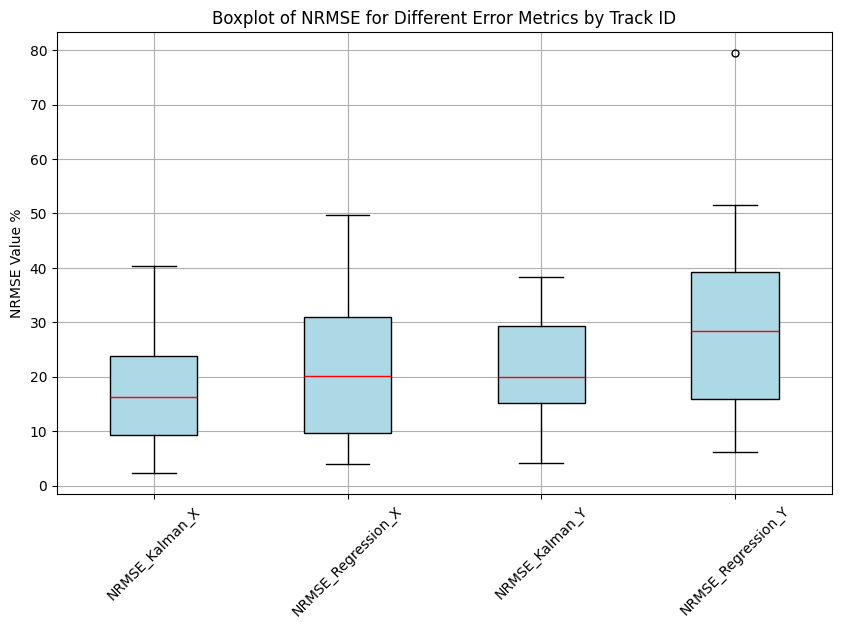

In [8]:
import matplotlib.pyplot as plt

# Extract the data from the DataFrame
data = [
    results['NRMSE_Kalman_X'],
    results['NRMSE_Regression_X'],
    results['NRMSE_Kalman_Y'],
    results['NRMSE_Regression_Y']
]

plt.figure(figsize=(10, 6))

# Create the boxplot
box = plt.boxplot(
    data,
    patch_artist=True,  # Allow filling the boxes with color
    meanline=True,      # Show the mean as a line
    whiskerprops=dict(color='black'),                       # Color for the whiskers
    capprops=dict(color='black'),                            # Color for the caps
    medianprops=dict(color='red'),                         # Color for the median line
    flierprops=dict(marker='o', color='black', markersize=5), # Color for the outliers
)

# Set the fill color for each box and mean color
for box_patch in box['boxes']:  # Access the boxes through the 'boxes' key
    box_patch.set_facecolor('lightblue')  # Set color for each box
    box_patch.set_edgecolor('black')       # Set outline color for each box
          

# Set x-tick labels
plt.xticks([1, 2, 3, 4], ['NRMSE_Kalman_X', 'NRMSE_Regression_X', 'NRMSE_Kalman_Y', 'NRMSE_Regression_Y'], rotation=45)

# Add labels and title
plt.title('Boxplot of NRMSE for Different Error Metrics by Track ID')
plt.ylabel('NRMSE Value %')

# Show the plot
plt.grid()
plt.show()